# В данной работе рассмотрен подход к решению задачи построения оптимальных маршрутов для инкассации платежных терминалов 

In [1993]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore") 
from keplergl import KeplerGl
import datetime

from networkx.algorithms.approximation import ( 
    simulated_annealing_tsp, 
)
import networkx as nx

## Предварительное ознакомление с данными и визуализация

In [2]:
#Загрузим данные по координатам терминалов
df_coord = pd.read_excel("../data/raw/terminal_data_hackathon v4.xlsx")

In [1968]:
#Визуализируем данные
map_test = KeplerGl(height = 750)
map_test.add_data(data = df_coord, name = 'map')
map_test

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'map': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,…

In [1552]:
#Загрузим данные по оборотам в терминалах
df1 = pd.read_excel("../data/raw/terminal_data_hackathon v4.xlsx",sheet_name = 1)
df1 = df1.rename(columns = {'остаток на 31.08.2022 (входящий)':'rest'})
df_times = pd.read_csv('../data/raw/times v4.csv')

In [1553]:
df1.head(3)

,TID,rest,2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000


In [1247]:
#Посмотрим некоторые метрики
df1['rest'].mean(),df1['rest'].median(),df1['rest'].quantile(0.95),df1['rest'].quantile(0.05)\
,df1['rest'].quantile(0.9999)

(319542.9447852761, 288000.0, 669550.0, 48450.0, 5527041.999999205)

<Axes: >

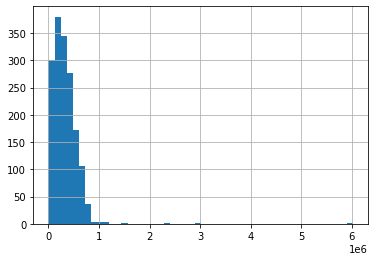

In [1554]:
#Распределение начального остатка
df1['rest'].hist(bins = 50)

In [1555]:
df1['rest'].max(),df1['rest'].min()

(6019000, 0)

## Подготовка функций для процесса оптимизации

### Нужно сбалансировать количество инкассаций по дням чтобы использовать минимальное количество машин, так как стоимость машины в день вносит наибольший вклад в стоимость всего процесса.

### Для этого будем добавлять к инкассациям, сработавшим по отсечке 1 миллион еще некоторое количество инкассаций - те у которых остается менее всего время до следующей инкассации

In [1624]:
#Один шаг расчета (на один день)
def one_step(df_test,dt='2022-09-01',trs = 1_000_000,fond_rate = rate0,one_ink_cost = one_ink_cost,n_ink = 140):
    
    """
    Функция предназначена для подсчета параметров, описывающих состояние сети при изменении дня
    """   
    
    df_temp = df_test.copy()
    df_stat = df_temp[['TID','rest','days_from_ink','perc_days','perc_sum']].copy()
    
    #Считаем затраты на процент начисляемый на остаток
    #cost_fond = df_temp['rest'].sum()*fond_rate
    cost_fond = df_temp['rest']*fond_rate
    #Все что больше лимита  записываем на инкассацию
    df_temp_ink = df_temp[df_temp['rest']>=trs]
    df_temp_ink['dt'] = dt
    df_temp_ink = df_temp_ink[['TID','rest','dt']]
    
    
    #Сколько еще нужно добавить инкассаций на день чтобы выровнять количество инкассаций по дням
    need_to_add = max(0,(n_ink - len(df_temp_ink)))
    #print('need_to_add',need_to_add)
    
    
    list_ink = list(df_temp_ink['TID'].unique())
    
    #Добавляем еще инкассации устройств - берем устройства с максимальным значением perc_day(отношение количества дней,
    #прошедших с момента инкассации к общему максимальному периоду инкассации (14дней))
    #т.е. добавляем устройства, у которых прошло наибольшее количество дней с момента прошлой инкассации
    df_ink_add = df_temp[~(df_temp['TID'].\
                           isin(list_ink))].sort_values(by = 'perc_days',ascending = False).head(need_to_add)
    df_ink_add['dt'] = dt
    df_ink_add = df_ink_add[['TID','rest','dt']]
    
    #Также на каждом шаге инкассируем все устройства, у которых уже подходит срок инкассации
    df_ink_add2 = df_temp[df_temp['perc_days']>0.9]
    df_ink_add2['dt'] = dt
    df_ink_add2 = df_ink_add2[['TID','rest','dt']]
    #Объединяем все инкассации воедино
    df_temp_ink = pd.concat([df_temp_ink,df_ink_add,df_ink_add2])
    df_temp_ink = df_temp_ink.drop_duplicates()
    
    #все проинкассированные за сегодня
    list_ink = list(df_temp_ink['TID'].unique())
    
    
    #Считаем затраты на инкассацию
    
    df_temp_ink['cost_ink'] = np.where(df_temp_ink['rest']<=1_000_000,100, df_temp_ink['rest']*0.0001)
    cost_ink = df_temp_ink['cost_ink'].sum()
    #df_temp_ink = df_temp_ink.drop(columns = ['cost_ink'])
    
    
    #Обнуляем остаток по проинкассированным
    df_temp['rest'][df_temp['TID'].isin(list_ink)]=0
     
    #Обновляем остаток по непроинкассированным
    df_temp['new_rest'] = df_temp['rest'] +df_temp[dt + ' 00:00:00']    
    df_temp['rest'] = df_temp['new_rest']
    #Обновляем количество дней с момента инкассации
    df_temp['days_from_ink']=df_temp['days_from_ink']+1    
    #Обнуляем количество дней с момента инкассации для проинкассированных устройств
    df_temp['days_from_ink'][df_temp['TID'].isin(list_ink)]=0
    #Вычисляем долю дней прошедших со дня инкассацц от общего числа возможных дней до инкассации
    df_temp['perc_days'] = df_temp['days_from_ink']/14
    #Вычисляем долю суммы текущего остатка от общей допустимой суммы
    df_temp['perc_sum'] = df_temp['rest']/1_000_000
    #Разница между долями по дням и по суммам
    df_temp['perc_delta'] = df_temp['perc_days'] - df_temp['perc_sum']
    
    
    #Накапливаем статистику
    
  
    df_stat = df_stat.merge(df_temp_ink[['TID','cost_ink']], on = 'TID', how = 'left')
    df_stat['cost_fond'] = cost_fond
    df_stat['dt']=dt
    df_temp.drop(columns = ['new_rest'],inplace = True)
    df_out = df_temp.copy()
    

    
    
    return df_out,df_temp_ink,df_stat
df_out,df_temp_ink,df_stat = \
one_step(df_test,dt='2022-09-01',fond_rate = rate0,one_ink_cost = one_ink_cost)    

## Ищем оптимальный путь для обхода терминалов при помощи метода имитации отжига

In [1969]:
def create_optimal_path(df_time_matrix: pd.DataFrame, starting_order: str) : 
        """Функция возвращает последовательность обхода.""" 
        # Создаем граф 
        df1 = df_time_matrix.copy() 
        df1 = df1[df1["Origin_tid"] != df1["Destination_tid"]] 
        G = nx.Graph() 
        G.add_weighted_edges_from( 
            [ 
                (client_1, cient_2, distance) 
                for client_1, cient_2, distance in zip(df1["Origin_tid"], df1["Destination_tid"], df1["Total_Time"]) 
            ] 
        ) 
 
        nodes = list(set(df1["Origin_tid"])) 
 
        # если нет стартовой ноды или неверно задана используем просто первую 
        if starting_order in nodes: 
            tsp = simulated_annealing_tsp( 
                G, init_cycle = "greedy", source=starting_order, max_iterations=100, seed=42 
            ) 
 
        else: 
            tsp = simulated_annealing_tsp( 
                G, init_cycle = "greedy", source=nodes[0], max_iterations=100, seed=42 
            ) 
 
        # убираем итоговое ребро в графе - 
        # алгоритм строит обход только с возвратом в начальную точку  - нам это не нужно по условию
        tsp.pop() 
 
        return tsp

In [1970]:
def calc_one_day_route_1(df_ink_one_day,df_times):
    """ Подсчет пути на один день
    
    Данная функция принимает все инкассации запланированные на день и строит маршрут, по которому 
    его объезжала бы ОДНА машина и считает сколько это займет у нее времени.
    Затем, зная общее время объезда этого пути одной машиной, мы делим это число на 12
    (по количеству часов работы каждой машины в день) и получаем приблизительное число машин машин требующихся
    на обслуживание всех точек за этот день.
    """
    df_temp = df_ink_one_day.copy()
    list_tids = list(df_temp['TID'])
    #df2 = pd.read_csv('times v4.csv')#.drop(columns = ['Unnamed: 0'])
    df_times = df_times[(df_times['Origin_tid'].isin(list_tids))&(df_times['Destination_tid'].isin(list_tids))]
    df_times_add = pd.DataFrame([[x,x,0] for x in set(df_times['Origin_tid'])],columns = df_times.columns)
    df_times = pd.concat([df_times,df_times_add]).sort_values(by = ['Origin_tid','Destination_tid'])
    df_times['Total_Time'] = df_times['Total_Time'].astype(float)
#     time_matrix = df2.pivot(index='Origin_tid', columns='Destination_tid', values='Total_Time')
#     time_matrix = time_matrix.values.tolist()
    #Получаем порядок обхода
    tsp = create_optimal_path(df_times, starting_order='') 
    #Выстраиваем заказы в полученном порядке и добавляем координаты
    df_temp = df_temp.set_index("TID") 
    df_temp = df_temp.loc[tsp] 
    df_temp = df_temp.reset_index() 
    df_temp["order"] = [x for x in range(0, len(df_temp))]
    df_temp = df_temp.merge(df_coord, on= "TID")
    
    #Сдвигаем координаты и тид  на одну ячейку для удобства подсчета времени объезда
    df_temp[['lon','lat','TID2']] = df_temp[['longitude','latitude','TID']].shift(-1)
    df_temp = df_temp.merge(df_times, left_on = ['TID','TID2'],right_on = ['Origin_tid','Destination_tid'],how='left')
    df_temp['working_time'] = 10
    df_temp['TID2'] = df_temp['TID2'].fillna(0)
    df_temp['TID'] = df_temp['TID'].astype(str)
    df_temp['TID2'] = df_temp['TID2'].astype(str)
    df_temp['all_sum'] = df_temp['Total_Time'] + df_temp['working_time']
    n_cars = (df_temp['all_sum'].sum()/60)/12

    return df_temp,n_cars

In [2139]:
def full_calc(df_test,list_of_dates,trs,one_ink_cost,n_ink = 140):
    """
    Подсчет на все даты    
    """
    

    
    full_list_of_terms = list(df_test['TID'].unique())
    
    ink_list = [] 
    list_stat = []
    routind_stat = []
    
    for num,dt in enumerate(list_of_dates):
        print('dt=',dt)
        #Подсчет одного дня
        df_test,df_temp_ink,df_stat = one_step(df_test,
                                               dt=dt,
                                               fond_rate = rate0,
                                               one_ink_cost = one_ink_cost,
                                               trs = trs,
                                               n_ink = n_ink) 
        print(len(df_stat))
        #Подсчет объезда точек
        df_temp,n_cars = calc_one_day_route_1(df_temp_ink,df_times)
        df_routing_stat_temp = pd.DataFrame([[dt,df_temp['all_sum'].sum(),n_cars]],columns = 
                                           ['dt','time','n_cars'])
        routind_stat.append(df_routing_stat_temp)
        
        
        ink_list.append(df_temp_ink)
        list_stat.append(df_stat)

        
        
    df_ink = pd.concat(ink_list)

    
    df_stat = pd.concat(list_stat)
    
    df_routind_stat = pd.concat(routind_stat)

    return df_stat,df_ink,df_routind_stat

In [2140]:
#Подготовим дополнительные поля для таблицы
df_test = df1.copy()
cols = list(df_test.columns[:2])+['days_from_ink','perc_days','perc_sum','perc_delta'] + list(df_test.columns[2:])
#Количество дней с момента инкассации
df_test['days_from_ink'] = 0
#Доля дней прошедших с прошлой инкассации от общего числа допустимых дней инкассаци(14 дней)
df_test['perc_days'] = 0
#Доля суммы остатка от общей допустимой суммы (1_000_000)
df_test['perc_sum'] = 0
df_test['perc_delta'] = 0
df_test = df_test[cols]

#Ставка, действующая на остаток средств в устройстве
rate0 = (2/100)/365
#стоимость 1ой инк - 
one_ink_cost = 100

In [2141]:
#Список дат
list_of_dates = list(df1.columns[2:])
list_of_dates = [x.replace(' 00:00:00','') for x in list_of_dates]
#full_list_of_terms = list(df_test['TID'].unique())

## Подбираем оптимальное количество инкассаций в день (используем данные за первые 60 дней)

In [2143]:
#Поиск оптимально числа инкассаций в день
st_final = []
full_stat = []
#Переберем от 80 до 250 инкассаций в день  - найдем лучшее по стоимости
for i in [x for x in range(100,200,5)]:
    print(i)
    df_stat,df_ink,df_routind_stat=\
    full_calc(df_test,list_of_dates[:60],trs = 10*100_000,one_ink_cost = one_ink_cost,n_ink = i)
    df_ink_stat = df_ink.groupby('dt').count().reset_index()[['dt','TID']].rename(columns = {'TID':'cnt'})
    n_cars = math.ceil(df_routind_stat['n_cars'].max())
    max_ink_days = df_stat['days_from_ink'].max()
    
    full_fond_cost = df_stat['cost_fond'].sum()
    full_ink_cost = df_stat['cost_ink'].sum()
    res_cost = full_fond_cost + full_ink_cost + math.ceil((n_cars))*60*20_000
    
    res = [n_cars,res_cost,max_ink_days]
    st_final_temp = pd.DataFrame([[i]+res],columns = ['n_ink','n_cars','res_cost','max_ink_days'])

    full_stat.append(df_stat)
    st_final.append(st_final_temp)
full_stat = pd.concat(full_stat)
st_final = pd.concat(st_final)


100
dt= 2022-09-01
1630
dt= 2022-09-02
1630
dt= 2022-09-03
1630
dt= 2022-09-04
1630
dt= 2022-09-05
1630
dt= 2022-09-06
1630
dt= 2022-09-07
1630
dt= 2022-09-08
1630
dt= 2022-09-09
1630
dt= 2022-09-10
1630
dt= 2022-09-11
1630
dt= 2022-09-12
1630
dt= 2022-09-13
1630
dt= 2022-09-14
1630
dt= 2022-09-15
1630
dt= 2022-09-16
1630
dt= 2022-09-17
1630
dt= 2022-09-18
1630
dt= 2022-09-19
1630
dt= 2022-09-20
1630
dt= 2022-09-21
1630
dt= 2022-09-22
1630
dt= 2022-09-23
1630
dt= 2022-09-24
1630
dt= 2022-09-25
1630
dt= 2022-09-26
1630
dt= 2022-09-27
1630
dt= 2022-09-28
1630
dt= 2022-09-29
1630
dt= 2022-09-30
1630
dt= 2022-10-01
1630
dt= 2022-10-02
1630
dt= 2022-10-03
1630
dt= 2022-10-04
1630
dt= 2022-10-05
1630
dt= 2022-10-06
1630
dt= 2022-10-07
1630
dt= 2022-10-08
1630
dt= 2022-10-09
1630
dt= 2022-10-10
1630
dt= 2022-10-11
1630
dt= 2022-10-12
1630
dt= 2022-10-13
1630
dt= 2022-10-14
1630
dt= 2022-10-15
1630
dt= 2022-10-16
1630
dt= 2022-10-17
1630
dt= 2022-10-18
1630
dt= 2022-10-19
1630
dt= 2022-10-20
1

dt= 2022-10-20
1630
dt= 2022-10-21
1630
dt= 2022-10-22
1630
dt= 2022-10-23
1630
dt= 2022-10-24
1630
dt= 2022-10-25
1630
dt= 2022-10-26
1630
dt= 2022-10-27
1630
dt= 2022-10-28
1630
dt= 2022-10-29
1630
dt= 2022-10-30
1630
135
dt= 2022-09-01
1630
dt= 2022-09-02
1630
dt= 2022-09-03
1630
dt= 2022-09-04
1630
dt= 2022-09-05
1630
dt= 2022-09-06
1630
dt= 2022-09-07
1630
dt= 2022-09-08
1630
dt= 2022-09-09
1630
dt= 2022-09-10
1630
dt= 2022-09-11
1630
dt= 2022-09-12
1630
dt= 2022-09-13
1630
dt= 2022-09-14
1630
dt= 2022-09-15
1630
dt= 2022-09-16
1630
dt= 2022-09-17
1630
dt= 2022-09-18
1630
dt= 2022-09-19
1630
dt= 2022-09-20
1630
dt= 2022-09-21
1630
dt= 2022-09-22
1630
dt= 2022-09-23
1630
dt= 2022-09-24
1630
dt= 2022-09-25
1630
dt= 2022-09-26
1630
dt= 2022-09-27
1630
dt= 2022-09-28
1630
dt= 2022-09-29
1630
dt= 2022-09-30
1630
dt= 2022-10-01
1630
dt= 2022-10-02
1630
dt= 2022-10-03
1630
dt= 2022-10-04
1630
dt= 2022-10-05
1630
dt= 2022-10-06
1630
dt= 2022-10-07
1630
dt= 2022-10-08
1630
dt= 2022-10-09
1

dt= 2022-10-09
1630
dt= 2022-10-10
1630
dt= 2022-10-11
1630
dt= 2022-10-12
1630
dt= 2022-10-13
1630
dt= 2022-10-14
1630
dt= 2022-10-15
1630
dt= 2022-10-16
1630
dt= 2022-10-17
1630
dt= 2022-10-18
1630
dt= 2022-10-19
1630
dt= 2022-10-20
1630
dt= 2022-10-21
1630
dt= 2022-10-22
1630
dt= 2022-10-23
1630
dt= 2022-10-24
1630
dt= 2022-10-25
1630
dt= 2022-10-26
1630
dt= 2022-10-27
1630
dt= 2022-10-28
1630
dt= 2022-10-29
1630
dt= 2022-10-30
1630
170
dt= 2022-09-01
1630
dt= 2022-09-02
1630
dt= 2022-09-03
1630
dt= 2022-09-04
1630
dt= 2022-09-05
1630
dt= 2022-09-06
1630
dt= 2022-09-07
1630
dt= 2022-09-08
1630
dt= 2022-09-09
1630
dt= 2022-09-10
1630
dt= 2022-09-11
1630
dt= 2022-09-12
1630
dt= 2022-09-13
1630
dt= 2022-09-14
1630
dt= 2022-09-15
1630
dt= 2022-09-16
1630
dt= 2022-09-17
1630
dt= 2022-09-18
1630
dt= 2022-09-19
1630
dt= 2022-09-20
1630
dt= 2022-09-21
1630
dt= 2022-09-22
1630
dt= 2022-09-23
1630
dt= 2022-09-24
1630
dt= 2022-09-25
1630
dt= 2022-09-26
1630
dt= 2022-09-27
1630
dt= 2022-09-28
1

In [2157]:
st_final[['n_ink','res_cost','n_cars','max_ink_days']].head(15).\
rename(columns = {'n_ink':'Количество инкассаций','res_cost':'Полные затраты',\
                  'n_cars':'Количество машин','max_ink_days':'Дней с прошлой инкассации'})

,Количество инкассаций,Полные затраты,Количество машин,Дней с прошлой инкассации
0,100,"19,624,637.31",14,13
0,105,"18,418,096.82",13,13
0,110,"16,015,125.80",11,13
0,115,"14,808,639.66",10,13
0,120,"12,403,816.70",8,13
0,125,"9,998,124.78",6,13
0,130,"9,983,286.43",6,13
0,135,"9,954,898.59",6,13
0,140,"9,929,324.66",6,12
0,145,"11,105,213.04",7,11


Text(0, 0.5, 'Полные затраты')

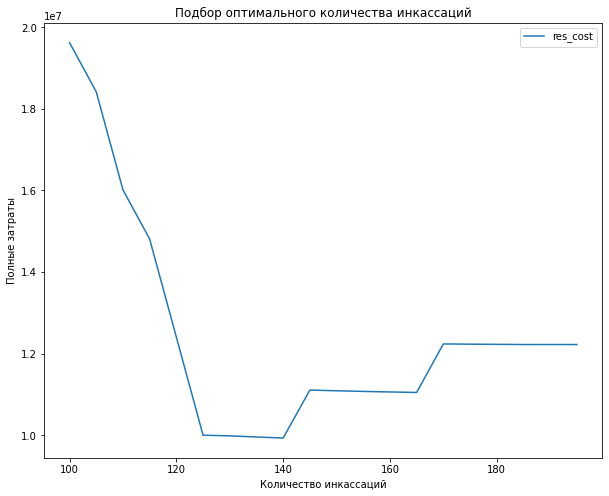

In [2164]:
ax = st_final[['n_ink','res_cost']].plot(x = 'n_ink',\
                                    y = 'res_cost',\
                                    title = 'Подбор оптимального количества инкассаций',
                                    figsize = (10,8))
ax.set_xlabel("Количество инкассаций")
ax.set_ylabel("Полные затраты")
ax.

## Получили оптимальное количство инкассаций в день равное 140, при котором стоимость всех расходов приблизительно 9.9М

In [1419]:
#Выбираем количество инкассаций в день равное 140 как наиболее оптимальное по стоимости

In [1649]:
st_final[st_final['n_ink']==140]

,n_ink,n_cars,res_cost,max_ink_days
0,140,6,9.929325e+06,12


In [ ]:
#Посчитаем отдельно все затратраты для параметра n_ink = 140

In [2201]:
df_stat,df_ink,df_routind_stat =\
full_calc(df_test,list_of_dates,trs = 10*100_000,one_ink_cost = one_ink_cost,n_ink = 140)

dt= 2022-09-01
1630
dt= 2022-09-02
1630
dt= 2022-09-03
1630
dt= 2022-09-04
1630
dt= 2022-09-05
1630
dt= 2022-09-06
1630
dt= 2022-09-07
1630
dt= 2022-09-08
1630
dt= 2022-09-09
1630
dt= 2022-09-10
1630
dt= 2022-09-11
1630
dt= 2022-09-12
1630
dt= 2022-09-13
1630
dt= 2022-09-14
1630
dt= 2022-09-15
1630
dt= 2022-09-16
1630
dt= 2022-09-17
1630
dt= 2022-09-18
1630
dt= 2022-09-19
1630
dt= 2022-09-20
1630
dt= 2022-09-21
1630
dt= 2022-09-22
1630
dt= 2022-09-23
1630
dt= 2022-09-24
1630
dt= 2022-09-25
1630
dt= 2022-09-26
1630
dt= 2022-09-27
1630
dt= 2022-09-28
1630
dt= 2022-09-29
1630
dt= 2022-09-30
1630
dt= 2022-10-01
1630
dt= 2022-10-02
1630
dt= 2022-10-03
1630
dt= 2022-10-04
1630
dt= 2022-10-05
1630
dt= 2022-10-06
1630
dt= 2022-10-07
1630
dt= 2022-10-08
1630
dt= 2022-10-09
1630
dt= 2022-10-10
1630
dt= 2022-10-11
1630
dt= 2022-10-12
1630
dt= 2022-10-13
1630
dt= 2022-10-14
1630
dt= 2022-10-15
1630
dt= 2022-10-16
1630
dt= 2022-10-17
1630
dt= 2022-10-18
1630
dt= 2022-10-19
1630
dt= 2022-10-20
1630


In [2202]:
#Таблица df_stat сейчас содержит данные для отчетов
df_stat

,TID,rest,days_from_ink,perc_days,perc_sum,cost_ink,cost_fond,dt
0,406136,160000,0,0.00,0.00,100.00,8.77,2022-09-01
1,406139,387000,0,0.00,0.00,NaN,21.21,2022-09-01
2,406145,287000,0,0.00,0.00,NaN,15.73,2022-09-01
3,406148,355000,0,0.00,0.00,NaN,19.45,2022-09-01
4,406180,597000,0,0.00,0.00,NaN,32.71,2022-09-01
...,...,...,...,...,...,...,...,...
1625,699578,43000,0,0.00,0.04,NaN,2.36,2022-11-30
1626,699579,63000,0,0.00,0.06,NaN,3.45,2022-11-30
1627,699629,62000,0,0.00,0.06,NaN,3.40,2022-11-30
1628,699641,85000,0,0.00,0.09,NaN,4.66,2022-11-30


## Построение маршрутов

In [2203]:
df_ink

,TID,rest,dt,cost_ink
245,608039,1132000,2022-09-01,113.20
560,630465,1053000,2022-09-01,105.30
574,634558,1517000,2022-09-01,151.70
814,635763,1010000,2022-09-01,101.00
1141,660401,6019000,2022-09-01,601.90
...,...,...,...,...
684,634924,528000,2022-11-30,100.00
1589,698971,924000,2022-11-30,100.00
685,634930,726000,2022-11-30,100.00
686,634934,875000,2022-11-30,100.00


In [2204]:
def create_routes_for_one_day(df_ink):
    
    """
    Функция принимает таблицу инкассаций за один день.
    Используется метод разделения пути для ОДНОЙ машины на участки пути
    для нескольких машин
    """
    #Разделяем на машины
    df_temp,n_cars = calc_one_day_route_1(df_ink,df_times)
    df_temp['cumm'] = df_temp["all_sum"].cumsum()
    df_temp['car'] = 0
    df_temp['_time_shift'] = df_temp['cumm'].shift(1).fillna(0)
    for i in range (1,10):
        #print(i)    
        df_temp['car'] = np.where(df_temp['_time_shift']>700*i,i,df_temp['car'])
        

    #Считаем время
    routes = []
    for car in df_temp['car'].unique():
        #print(len(df_temp[df_temp['car']==car]))
        dt = df_ink['dt'].values[0]
        
        dt = datetime.datetime.strptime(dt, '%Y-%m-%d')
        print(dt)
        _d = df_temp[df_temp['car']==car]
        _d['cumm'] = _d["all_sum"].cumsum()
        _d['_time_shift'] = _d['cumm'].shift(1).fillna(0)
        _d['start_time'] = 480
        _d['finish_time'] = 0
        _d['start_time'] = _d['start_time']+_d['_time_shift']
        _d['finish_time'] = _d['start_time']+_d['working_time']
        routes.append(_d)
    routes = pd.concat(routes)
    routes['start_time'] = routes['start_time'].apply(lambda x: dt+(datetime.timedelta(minutes=x)))
    routes['finish_time'] = routes['finish_time'].apply(lambda x: dt+(datetime.timedelta(minutes=x)))
    
    return routes

In [2205]:
all_routes = []
for dt in df_ink['dt'].unique():
    print(dt)
    routes = create_routes_for_one_day(df_ink[df_ink['dt']==dt])
    all_routes.append(routes)
all_routes = pd.concat(all_routes)

2022-09-01
2022-09-01 00:00:00
2022-09-01 00:00:00
2022-09-01 00:00:00
2022-09-01 00:00:00
2022-09-01 00:00:00
2022-09-01 00:00:00
2022-09-02
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-02 00:00:00
2022-09-03
2022-09-03 00:00:00
2022-09-03 00:00:00
2022-09-03 00:00:00
2022-09-03 00:00:00
2022-09-03 00:00:00
2022-09-03 00:00:00
2022-09-04
2022-09-04 00:00:00
2022-09-04 00:00:00
2022-09-04 00:00:00
2022-09-04 00:00:00
2022-09-04 00:00:00
2022-09-04 00:00:00
2022-09-05
2022-09-05 00:00:00
2022-09-05 00:00:00
2022-09-05 00:00:00
2022-09-05 00:00:00
2022-09-05 00:00:00
2022-09-05 00:00:00
2022-09-06
2022-09-06 00:00:00
2022-09-06 00:00:00
2022-09-06 00:00:00
2022-09-06 00:00:00
2022-09-06 00:00:00
2022-09-06 00:00:00
2022-09-07
2022-09-07 00:00:00
2022-09-07 00:00:00
2022-09-07 00:00:00
2022-09-07 00:00:00
2022-09-07 00:00:00
2022-09-07 00:00:00
2022-09-08
2022-09-08 00:00:00
2022-09-08 00:00:00
2022-09-08 0

2022-11-03 00:00:00
2022-11-03 00:00:00
2022-11-03 00:00:00
2022-11-03 00:00:00
2022-11-03 00:00:00
2022-11-03 00:00:00
2022-11-04
2022-11-04 00:00:00
2022-11-04 00:00:00
2022-11-04 00:00:00
2022-11-04 00:00:00
2022-11-04 00:00:00
2022-11-04 00:00:00
2022-11-05
2022-11-05 00:00:00
2022-11-05 00:00:00
2022-11-05 00:00:00
2022-11-05 00:00:00
2022-11-05 00:00:00
2022-11-05 00:00:00
2022-11-06
2022-11-06 00:00:00
2022-11-06 00:00:00
2022-11-06 00:00:00
2022-11-06 00:00:00
2022-11-06 00:00:00
2022-11-06 00:00:00
2022-11-07
2022-11-07 00:00:00
2022-11-07 00:00:00
2022-11-07 00:00:00
2022-11-07 00:00:00
2022-11-07 00:00:00
2022-11-07 00:00:00
2022-11-08
2022-11-08 00:00:00
2022-11-08 00:00:00
2022-11-08 00:00:00
2022-11-08 00:00:00
2022-11-08 00:00:00
2022-11-08 00:00:00
2022-11-09
2022-11-09 00:00:00
2022-11-09 00:00:00
2022-11-09 00:00:00
2022-11-09 00:00:00
2022-11-09 00:00:00
2022-11-09 00:00:00
2022-11-10
2022-11-10 00:00:00
2022-11-10 00:00:00
2022-11-10 00:00:00
2022-11-10 00:00:00
202

In [2207]:
all_routes

,TID,rest,dt,cost_ink,order,longitude,latitude,lon,lat,TID2,Origin_tid,Destination_tid,Total_Time,working_time,all_sum,cumm,car,_time_shift,start_time,finish_time
0,657920,223000,2022-09-01,100.00,0,36.98,56.19,36.98,56.18,646868.0,"657,920.00","646,868.00",2.29,10,12.29,12.29,0,0.00,2022-09-01 08:00:00.000,2022-09-01 08:10:00.000
1,646868,225000,2022-09-01,100.00,1,36.98,56.18,36.99,56.18,677522.0,"646,868.00","677,522.00",3.02,10,13.02,25.31,0,12.29,2022-09-01 08:12:17.400,2022-09-01 08:22:17.400
2,677522,1042000,2022-09-01,104.20,2,36.99,56.18,37.01,56.17,668584.0,"677,522.00","668,584.00",4.25,10,14.25,39.56,0,25.31,2022-09-01 08:25:18.600,2022-09-01 08:35:18.600
3,668584,193000,2022-09-01,100.00,3,37.01,56.17,37.23,55.99,646867.0,"668,584.00","646,867.00",28.19,10,38.19,77.75,0,39.56,2022-09-01 08:39:33.600,2022-09-01 08:49:33.600
4,646867,595000,2022-09-01,100.00,4,37.23,55.99,37.15,55.98,646935.0,"646,867.00","646,935.00",9.97,10,19.97,97.72,0,77.75,2022-09-01 09:17:45.000,2022-09-01 09:27:45.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,634975,607000,2022-11-30,100.00,135,36.72,55.41,36.73,55.38,635204.0,"634,975.00","635,204.00",9.68,10,19.68,19.68,5,0.00,2022-11-30 08:00:00.000,2022-11-30 08:10:00.000
136,635204,566000,2022-11-30,100.00,136,36.73,55.38,37.01,56.17,668584.0,"635,204.00","668,584.00",104.98,10,114.98,134.66,5,19.68,2022-11-30 08:19:40.800,2022-11-30 08:29:40.800
137,668584,621000,2022-11-30,100.00,137,37.01,56.17,36.92,56.17,676339.0,"668,584.00","676,339.00",8.77,10,18.77,153.43,5,134.66,2022-11-30 10:14:39.600,2022-11-30 10:24:39.600
138,676339,573000,2022-11-30,100.00,138,36.92,56.17,38.13,56.29,634991.0,"676,339.00","634,991.00",106.41,10,116.41,269.84,5,153.43,2022-11-30 10:33:25.800,2022-11-30 10:43:25.800


In [2196]:
#Получаем таблицу со временем посещения терминалов
#all_routes[all_routes['car']==4]

In [1988]:
with open('config_map1.json','r') as f:
    config_map1 = json.load(f)

In [1989]:
map_test = KeplerGl(height = 750,config = config_map1)
map_test.add_data(data = all_routes[all_routes['dt']=='2022-09-01'], name = 'map')
map_test

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'guor9mc', 'type': …

## Отчеты

### Остатки на конец дня

In [2010]:
df_rests = df_stat.copy()

In [2011]:
df_rep_rests_end_day = df_rests.pivot(index = 'TID',columns = 'dt',values = 'rest')

In [2012]:
df_rep_rests_end_day.head(5)

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
TID,,,,,,,,,,,,,,,,,,,,,
406136,160000,90000,195000,294000,401000,511000,571000,646000,735000,830000,...,301000,392000,470000,470000,635000,635000,824000,930000,1024000,75000
406139,387000,490000,696000,864000,124000,202000,367000,531000,705000,793000,...,1132000,164000,317000,468000,625000,831000,1013000,123000,261000,373000
406145,287000,430000,566000,690000,807000,930000,1070000,139000,277000,395000,...,1079000,119000,219000,398000,567000,685000,803000,917000,1045000,121000
406148,355000,405000,478000,531000,596000,671000,771000,824000,876000,958000,...,411000,459000,514000,579000,664000,759000,827000,889000,0,118000
406180,597000,693000,775000,846000,918000,1004000,55000,110000,185000,260000,...,808000,890000,946000,70000,129000,234000,304000,381000,468000,527000


In [2013]:
df_rep_rests_end_day.to_excel('Остатки_на_конец_дня.xlsx')

### Стоимость фондирования

In [2014]:
df_rep_fond = df_rests.pivot(index = 'TID',columns = 'dt',values = 'cost_fond')

In [2015]:
df_rep_fond.head(5)

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
TID,,,,,,,,,,,,,,,,,,,,,
406136,8.767123,4.931507,10.684932,16.109589,21.972603,28.000000,31.287671,35.397260,40.273973,45.479452,...,16.493151,21.479452,25.753425,25.753425,34.794521,34.794521,45.150685,50.958904,56.109589,4.109589
406139,21.205479,26.849315,38.136986,47.342466,6.794521,11.068493,20.109589,29.095890,38.630137,43.452055,...,62.027397,8.986301,17.369863,25.643836,34.246575,45.534247,55.506849,6.739726,14.301370,20.438356
406145,15.726027,23.561644,31.013699,37.808219,44.219178,50.958904,58.630137,7.616438,15.178082,21.643836,...,59.123288,6.520548,12.000000,21.808219,31.068493,37.534247,44.000000,50.246575,57.260274,6.630137
406148,19.452055,22.191781,26.191781,29.095890,32.657534,36.767123,42.246575,45.150685,48.000000,52.493151,...,22.520548,25.150685,28.164384,31.726027,36.383562,41.589041,45.315068,48.712329,0.000000,6.465753
406180,32.712329,37.972603,42.465753,46.356164,50.301370,55.013699,3.013699,6.027397,10.136986,14.246575,...,44.273973,48.767123,51.835616,3.835616,7.068493,12.821918,16.657534,20.876712,25.643836,28.876712


In [2016]:
df_rep_fond.to_excel('Стоимость_фондирования.xlsx')

### Cтоимость инкассации

In [2017]:
df_rep_ink = df_rests.pivot(index = 'TID',columns = 'dt',values = 'cost_ink').fillna(0)

In [2018]:
df_rep_ink.head(5)

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
TID,,,,,,,,,,,,,,,,,,,,,
406136,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.4,0.0
406139,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113.2,0.0,0.0,0.0,0.0,0.0,101.3,0.0,0.0,0.0
406145,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.0,0.0,...,107.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.5,0.0
406148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
406180,0.0,0.0,0.0,0.0,0.0,100.4,0.0,0.0,0.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2019]:
df_rep_ink.to_excel('Cтоимость_инкассации.xlsx')

### Итоговый отчет

In [2117]:
final_rep_part_1 = df_stat[['dt','cost_fond']].groupby('dt').sum().T

In [2118]:
final_rep_part_2 = df_stat[['dt','cost_ink']].groupby('dt').sum().T

In [2119]:
final_rep_bron = df_stat[['dt','cost_fond']].groupby('dt').sum()

In [2120]:
final_rep_bron['cost_fond'] = 6*20_000

In [2121]:
final_rep_bron = final_rep_bron.rename(columns = {'cost_fond':'стоимость броневиков'})

In [2122]:
final_rep_bron.T

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
стоимость броневиков,120000,120000,120000,120000,120000,120000,120000,120000,120000,120000,...,120000,120000,120000,120000,120000,120000,120000,120000,120000,120000


In [2123]:
final_rep = pd.concat([final_rep_part_1,final_rep_part_2,final_rep_bron.T])

In [2124]:
final_rep

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
cost_fond,"28,540.00","30,679.73","33,103.40","34,249.37","34,850.79","35,003.84","34,984.71","34,522.25","33,965.59","33,496.05",...,"30,011.67","29,474.30","29,137.81","28,850.19","28,768.99","29,627.95","29,924.93","29,550.19","29,942.85","29,786.79"
cost_ink,"14,944.00","14,081.10","14,156.30","14,299.20","14,120.90","14,183.90","14,243.60","14,319.40","14,285.30","14,310.60",...,"14,172.30","14,245.90","14,174.50","14,246.80","14,199.50","14,223.50","14,332.00","14,189.10","14,233.80","14,292.20"
стоимость броневиков,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00",...,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00"


In [2126]:
final_rep = final_rep.append(final_rep.sum(numeric_only=True), ignore_index=True)

In [2127]:
final_rep.index = ['стоимость фондирования','стоимость инкассации','стоимость броневиков','итого']

In [2128]:
final_rep

dt,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
стоимость фондирования,"28,540.00","30,679.73","33,103.40","34,249.37","34,850.79","35,003.84","34,984.71","34,522.25","33,965.59","33,496.05",...,"30,011.67","29,474.30","29,137.81","28,850.19","28,768.99","29,627.95","29,924.93","29,550.19","29,942.85","29,786.79"
стоимость инкассации,"14,944.00","14,081.10","14,156.30","14,299.20","14,120.90","14,183.90","14,243.60","14,319.40","14,285.30","14,310.60",...,"14,172.30","14,245.90","14,174.50","14,246.80","14,199.50","14,223.50","14,332.00","14,189.10","14,233.80","14,292.20"
стоимость броневиков,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00",...,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00"
итого,"163,484.00","164,760.83","167,259.70","168,548.57","168,971.69","169,187.74","169,228.31","168,841.65","168,250.89","167,806.65",...,"164,183.97","163,720.20","163,312.31","163,096.99","162,968.49","163,851.45","164,256.93","163,739.29","164,176.65","164,078.99"


In [2129]:
final_rep.to_excel('итоговый отчет.xlsx')

### Отчет по маршрутам

In [2208]:
routes_rep = all_routes[['dt','car','TID','start_time','finish_time']]

In [2209]:
routes_rep

,dt,car,TID,start_time,finish_time
0,2022-09-01,0,657920,2022-09-01 08:00:00.000,2022-09-01 08:10:00.000
1,2022-09-01,0,646868,2022-09-01 08:12:17.400,2022-09-01 08:22:17.400
2,2022-09-01,0,677522,2022-09-01 08:25:18.600,2022-09-01 08:35:18.600
3,2022-09-01,0,668584,2022-09-01 08:39:33.600,2022-09-01 08:49:33.600
4,2022-09-01,0,646867,2022-09-01 09:17:45.000,2022-09-01 09:27:45.000
...,...,...,...,...,...
135,2022-11-30,5,634975,2022-11-30 08:00:00.000,2022-11-30 08:10:00.000
136,2022-11-30,5,635204,2022-11-30 08:19:40.800,2022-11-30 08:29:40.800
137,2022-11-30,5,668584,2022-11-30 10:14:39.600,2022-11-30 10:24:39.600
138,2022-11-30,5,676339,2022-11-30 10:33:25.800,2022-11-30 10:43:25.800


In [2210]:
routes_rep.to_excel('routes_rep.xlsx')